# Binary Classifier on HTTP CSIC Dataset (Supervised Anomaly Detection)

## Section 1 - Pre-Processing

As this data set contains attributes which aren't as helpful as it is, features need to be mainpulated in order to create better features which would aid the classifying process.

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=100

In [2]:
normalTrainingDataFrame = pd.read_csv("normalTrafficTraining_http_requests.csv")
normalTestDataFrame = pd.read_csv("normalTrafficTest_http_requests.csv")
anomalousTestDataFrame = pd.read_csv("anomalousTrafficTest_http_requests.csv")

In [3]:
combinedDataFrame = normalTrainingDataFrame.append(normalTestDataFrame, ignore_index=True)
combinedDataFrame = combinedDataFrame.append(anomalousTestDataFrame, ignore_index=True)
combinedDataFrame = combinedDataFrame.drop(columns="Unnamed: 0")

### Dropping columns where feature is trivial (every row has same value)

In [4]:
# Finding the indexes of the columns to drop

num_columns = len(combinedDataFrame.columns)
cols_to_drop_index = []

for i in range(num_columns):
    if len(combinedDataFrame.iloc[:,i].value_counts()) == 1:
        cols_to_drop_index = cols_to_drop_index + [i]

In [5]:
# Finding the name of the columns to drop

combined_df_columns = combinedDataFrame.columns
cols_to_drop_name = []

for i in range(len(cols_to_drop_index)):
    next_drop = combined_df_columns[cols_to_drop_index[i]]
    cols_to_drop_name = cols_to_drop_name + [next_drop]

In [6]:
combinedDataFrame.drop(cols_to_drop_name, axis=1, inplace=True)

### Manual Manipulation of Columns

In [7]:
combinedDataFrame['Host'] = combinedDataFrame['Host'].apply(lambda x: x[10:])

In [8]:
combinedDataFrame['Cookie'].apply(lambda x: x[:11]).value_counts()

JSESSIONID=    97065
Name: Cookie, dtype: int64

In [9]:
# Dropping the "JSESSIONID=" bit to leave the hash behind
combinedDataFrame['Cookie'] = combinedDataFrame['Cookie'].apply(lambda x: x[11:])

In [10]:
combinedDataFrame.rename(columns={'Cookie':'Cookie_JSESSIONID'}, inplace=True)

In [11]:
# checking if all requests begin with "http://localhost:8080"
combinedDataFrame['Request_Address'].apply(lambda x: x[:21]).value_counts()

http://localhost:8080    97065
Name: Request_Address, dtype: int64

In [12]:
# Dropping "http://localhost:8080"
combinedDataFrame.rename(columns={'Request_Address':'Request_Address_URI'}, inplace=True)
combinedDataFrame['Request_Address_URI'] = combinedDataFrame['Request_Address_URI'].apply(lambda x: x[21:])

In [13]:
combinedDataFrame['Content-Length'] = combinedDataFrame['Content-Length'].replace(np.nan, 0)

In [14]:
combinedDataFrame.groupby('Normal_Access')['Request_Type'].value_counts()

Normal_Access  Request_Type
No             GET             15088
               POST             9580
               PUT               397
Yes            GET             56000
               POST            16000
Name: Request_Type, dtype: int64

In [15]:
combinedDataFrame.groupby('Normal_Access')['Host'].value_counts()

Normal_Access  Host
No             8080    24668
               9090      397
Yes            8080    72000
Name: Host, dtype: int64

In [16]:
# Dropping column as every session ID in table is unique, cannot link attacks to particular sessions
# Could not find any links between this attribute and URI 
combinedDataFrame = combinedDataFrame.drop(columns='Cookie_JSESSIONID')

In [17]:
# Re-ordering columns
cols = combinedDataFrame.columns.tolist()
cols = cols[-1:] + cols[:-1]

combinedDataFrame = combinedDataFrame[cols]


In [18]:
combinedDataFrame['No_of_slashes'] = combinedDataFrame.apply(lambda row: row.Request_Address_URI.count("/"), axis=1)
combinedDataFrame['No_of_questions'] = combinedDataFrame.apply(lambda row: row.Request_Address_URI.count("?"), axis=1)
combinedDataFrame['No_of_equals'] = combinedDataFrame.apply(lambda row: row.Request_Address_URI.count("="), axis=1)

In [19]:
combinedDataFrame['Put_Request'] = combinedDataFrame['Request_Type'] == "PUT"
combinedDataFrame['9090_Port'] =  combinedDataFrame['Host'] == "9090"

In [20]:
combinedDataFrame.groupby('Put_Request')['9090_Port'].value_counts()

Put_Request  9090_Port
False        False        96668
True         True           397
Name: 9090_Port, dtype: int64

In [21]:
# Every put request is always to port 9090 in dataset
combinedDataFrame = combinedDataFrame.drop(columns='9090_Port')
combinedDataFrame.rename(columns={'Put_Request':'PUT_and_9090'}, inplace=True)
# Only port 9090 has attacks, rest is port 8080
combinedDataFrame = combinedDataFrame.drop(columns='Host')

In [22]:
combinedDataFrame['No_of_ampersands'] = combinedDataFrame.apply(lambda row: row.Request_Address_URI.count("&"), axis=1)
combinedDataFrame['No_of_periods'] = combinedDataFrame.apply(lambda row: row.Request_Address_URI.count("."), axis=1)

In [23]:
combinedDataFrame['Length_of_URI'] = combinedDataFrame.apply(lambda row: len(row.Request_Address_URI), axis=1)

In [24]:
def get_ext(uri):
    tokens = uri.split(".")
    if len(tokens)==1:
        return ""
    else:
        return tokens[len(tokens)-1]
    
def get_final_file(uri):
    tokens = uri.split("/")
    return tokens[len(tokens)-1]

# To try and find bad extensions
def max_no_of_periods_between_slashes(uri):
    num_found = 0
    tokens = uri.split("/")
    for token in tokens:
        num_in_token = token.count(".")
        if num_in_token > num_found:
            num_found = num_in_token
    return num_found    
    

In [25]:
combinedDataFrame['URI_ext'] = combinedDataFrame.apply(lambda row: get_ext(row.Request_Address_URI), axis=1)
combinedDataFrame['URI_file'] = combinedDataFrame.apply(lambda row: get_final_file(row.Request_Address_URI), axis=1)
combinedDataFrame['Max_no_periods_between_slashes'] = combinedDataFrame.apply(lambda row: max_no_of_periods_between_slashes(row.Request_Address_URI), axis=1)
combinedDataFrame['URI_ext_end_with_alpha'] = combinedDataFrame.apply(lambda row: row.URI_ext[-1:].isalpha(), axis=1)
combinedDataFrame['URI_ext_end_with_numeric'] = combinedDataFrame.apply(lambda row: row.URI_ext[-1:].isdigit(), axis=1)
combinedDataFrame['URI_has_CAPS'] = combinedDataFrame.apply(lambda row: any(x.isupper() for x in row.Request_Address_URI), axis=1)

In [26]:
combinedDataFrame['URI_ext_shortened'] = combinedDataFrame.apply(lambda row: row.URI_ext[:3], axis=1)

In [27]:
import math

# Referenced from https://stackoverflow.com/questions/1547899/which-characters-make-a-url-invalid 
URI_CHARS_LIST = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-._~:/?#[]@!$&'()*+,;="

def shannon_entropy(data, iterator):
    """
    Borrowed from http://blog.dkbza.org/2007/05/scanning-data-for-entropy-anomalies.html
    """
    if not data:
        return 0
    entropy = 0
    for x in iterator:
        p_x = float(data.count(x))/len(data)
        if p_x > 0:
            entropy += - p_x*math.log(p_x, 2)
    return entropy

combinedDataFrame['Entropy'] = combinedDataFrame.apply(lambda row: shannon_entropy(row.Request_Address_URI, URI_CHARS_LIST), axis=1)

In [28]:
combinedDataFrame['Length_of_URI_File'] = combinedDataFrame.apply(lambda row: len(row.URI_file), axis=1)

In [29]:
# Static Attacks Detection

# To detect JSESSION_ID in URL Rewrite, none of rows contain "jsessionid="
combinedDataFrame['Has_set-cookie'] = combinedDataFrame.apply(lambda row: "Set-cookie" in row.Request_Address_URI, axis=1)
# Identify accesses to backup files
combinedDataFrame['Access_backup'] = combinedDataFrame.apply(lambda row: (row.URI_ext).lower() == "bak", axis=1)
# Identify accesses to config files
combinedDataFrame['Access_config'] = combinedDataFrame.apply(lambda row: (row.URI_ext).lower() == "cnf", axis=1)
# Identify accesses to default index.html file
combinedDataFrame['Access_index_html'] = combinedDataFrame.apply(lambda row: "index.html" in row.Request_Address_URI, axis=1)

In [30]:
# Dynamic Attacks Detection

# Identify possible SQL Commands
# can change to a count rather than binary
def spot_sql(uri):
    return ("SELECT" in uri or "FROM" in uri or "UNION" in uri or "OR" in uri or "--" in uri or "/**/" in uri or "INSERT" in uri or "UPDATE" in uri or "DELETE" in uri or "CREATE" in uri or "ALTER" in uri or "DROP" in uri)

combinedDataFrame['Possible_SQL_Injection'] = combinedDataFrame.apply(lambda row: spot_sql(row.Request_Address_URI), axis=1)

# Possible CRLF injection - not found
crlf_list = combinedDataFrame.apply(lambda row: "%0d%0a" in row.Request_Address_URI, axis=1)

count_crlf =0
for lin in crlf_list:
    if lin:
        count_crlf = count_crlf + 1
        
print(count_crlf)

0


In [31]:
# Cross site scripting
combinedDataFrame['Contains_script_word'] = combinedDataFrame.apply(lambda row: "script" in row.Request_Address_URI.lower(), axis=1)
combinedDataFrame['Contains_another_http'] = combinedDataFrame.apply(lambda row: "http" in row.Request_Address_URI.lower(), axis=1)

# Buffer overflows
# No feature I can find to detect this threat

In [32]:
# Dropping columns, enumeration to form dataFrame
testingDataFrame = combinedDataFrame.drop(columns=['Request_Address_URI'])

In [33]:
testingDataFrame.head()

,Normal_Access,Request_Type,Content-Length,No_of_slashes,No_of_questions,No_of_equals,PUT_and_9090,No_of_ampersands,No_of_periods,Length_of_URI,URI_ext,URI_file,Max_no_periods_between_slashes,URI_ext_end_with_alpha,URI_ext_end_with_numeric,URI_has_CAPS,URI_ext_shortened,Entropy,Length_of_URI_File,Has_set-cookie,Access_backup,Access_config,Access_index_html,Possible_SQL_Injection,Contains_script_word,Contains_another_http
0,Yes,GET,0.0,2,0,0,False,0,1,18,jsp,index.jsp,1,True,False,False,jsp,3.614369,9,False,False,False,False,False,False,False
1,Yes,GET,0.0,3,1,5,False,4,1,96,jsp?id=3&nombre=Vino+Rioja&precio=100&cantidad...,anadir.jsp?id=3&nombre=Vino+Rioja&precio=100&c...,1,True,False,True,jsp,4.544789,79,False,False,False,False,False,False,False
2,Yes,POST,68.0,3,0,0,False,0,1,27,jsp,anadir.jsp,1,True,False,False,jsp,4.004344,10,False,False,False,False,False,False,False
3,Yes,GET,0.0,3,1,5,False,4,1,95,jsp?modo=entrar&login=choong&pwd=d1se3ci%F3n&r...,autenticar.jsp?modo=entrar&login=choong&pwd=d1...,1,True,False,True,jsp,4.584236,78,False,False,False,False,False,False,False
4,Yes,POST,63.0,3,0,0,False,0,1,31,jsp,autenticar.jsp,1,True,False,False,jsp,4.018082,14,False,False,False,False,False,False,False


In [34]:
testingDataFrame = testingDataFrame.replace([True, False], [1, 0])
testingDataFrame = testingDataFrame.replace(['No', 'Yes'], [0,1])

In [35]:
# ENUMERATING REQUEST TYPE
testingDataFrame = testingDataFrame.replace(["GET", "POST", "PUT"], [0,1,2])

In [36]:
# dropping these columns: URI ext, URI file, URI_ext_shortened (value already extracted in pre-processing?)
testingDataFrame = testingDataFrame.drop(columns=['URI_ext', 'URI_file', 'URI_ext_shortened'])

## Section 2 - Baseline Models Testing

In [37]:
# stratified sampling

from sklearn.model_selection import train_test_split

combined_table_features = testingDataFrame.drop(columns='Normal_Access')
combined_table_target = testingDataFrame['Normal_Access']

train_features, test_features, train_target, test_target = train_test_split(combined_table_features, combined_table_target, test_size=0.1, shuffle=True, stratify=combined_table_target)

In [38]:
from sklearn.svm import SVC

svc_clf_lin = SVC(kernel='linear')
svc_clf_lin.fit(train_features, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [39]:
svc_clf_rbf = SVC()
svc_clf_rbf.fit(train_features, train_target)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(train_features, train_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


result_df_columns = ['Classifier', 'Accuracy', 'Precision (Micro)', 'Precision (Weighted)', 'Recall (Micro)', 'Recall (Weighted)', 'F-1 (Micro)', 'F1 (Weighted)']
clf_cmp_dataframe = pd.DataFrame(columns=result_df_columns)

rf_pred_list = rf_clf.predict(test_features)
rf_acc = accuracy_score(test_target, rf_pred_list)
rf_prec_mic = precision_score(test_target, rf_pred_list, average='micro')
rf_prec_mac = precision_score(test_target, rf_pred_list, average='weighted')
rf_rec_mic = recall_score(test_target, rf_pred_list, average='micro')
rf_rec_mac = recall_score(test_target, rf_pred_list, average='weighted')
rf_f1_mic = f1_score(test_target, rf_pred_list, average='micro')
rf_f1_mac = f1_score(test_target, rf_pred_list, average='weighted')

rf_res = ["RF", rf_acc, rf_prec_mic, rf_prec_mac, rf_rec_mic, rf_rec_mac, rf_f1_mic, rf_f1_mac]
rf_df = pd.DataFrame([rf_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(rf_df, ignore_index=True)

In [43]:
# LR

lr_pred_list = lr_clf.predict(test_features)
lr_acc = accuracy_score(test_target, lr_pred_list)
lr_prec_mic = precision_score(test_target, lr_pred_list, average='micro')
lr_prec_mac = precision_score(test_target, lr_pred_list, average='weighted')
lr_rec_mic = recall_score(test_target, lr_pred_list, average='micro')
lr_rec_mac = recall_score(test_target, lr_pred_list, average='weighted')
lr_f1_mic = f1_score(test_target, lr_pred_list, average='micro')
lr_f1_mac = f1_score(test_target, lr_pred_list, average='weighted')

lr_res = ["LR", lr_acc, lr_prec_mic, lr_prec_mac, lr_rec_mic, lr_rec_mac, lr_f1_mic, lr_f1_mac]
lr_df = pd.DataFrame([lr_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(lr_df, ignore_index=True)

In [44]:
# SVC linear
svc_lin_pred_list = svc_clf_lin.predict(test_features)
svc_lin_acc = accuracy_score(test_target, svc_lin_pred_list)
svc_lin_prec_mic = precision_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_prec_mac = precision_score(test_target, svc_lin_pred_list, average='weighted')
svc_lin_rec_mic = recall_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_rec_mac = recall_score(test_target, svc_lin_pred_list, average='weighted')
svc_lin_f1_mic = f1_score(test_target, svc_lin_pred_list, average='micro')
svc_lin_f1_mac = f1_score(test_target, svc_lin_pred_list, average='weighted')

svc_lin_res = ["SVC Linear", svc_lin_acc, svc_lin_prec_mic, svc_lin_prec_mac, svc_lin_rec_mic, svc_lin_rec_mac, svc_lin_f1_mic, svc_lin_f1_mac]
svc_lin_df = pd.DataFrame([svc_lin_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(svc_lin_df, ignore_index=True)

In [45]:
# SVC rbf
svc_rbf_pred_list = svc_clf_rbf.predict(test_features)
svc_rbf_acc = accuracy_score(test_target, svc_rbf_pred_list)
svc_rbf_prec_mic = precision_score(test_target, svc_rbf_pred_list, average='micro')
svc_rbf_prec_mac = precision_score(test_target, svc_rbf_pred_list, average='weighted')
svc_rbf_rec_mic = recall_score(test_target, svc_rbf_pred_list, average='micro')
svc_rbf_rec_mac = recall_score(test_target, svc_rbf_pred_list, average='weighted')
svc_rbf_f1_mic = f1_score(test_target, svc_rbf_pred_list, average='micro')
svc_rbf_f1_mac = f1_score(test_target, svc_rbf_pred_list, average='weighted')

svc_rbf_res = ["SVC RBF", svc_rbf_acc, svc_rbf_prec_mic, svc_rbf_prec_mac, svc_rbf_rec_mic, svc_rbf_rec_mac, svc_rbf_f1_mic, svc_rbf_f1_mac]
svc_rbf_df = pd.DataFrame([svc_rbf_res], columns=result_df_columns)

clf_cmp_dataframe = clf_cmp_dataframe.append(svc_rbf_df, ignore_index=True)

In [46]:
clf_cmp_dataframe.sort_values('Accuracy')

,Classifier,Accuracy,Precision (Micro),Precision (Weighted),Recall (Micro),Recall (Weighted),F-1 (Micro),F1 (Weighted)
1,LR,0.810961,0.810961,0.808215,0.810961,0.810961,0.810961,0.783848
2,SVC Linear,0.816730,0.816730,0.818452,0.816730,0.816730,0.816730,0.789501
3,SVC RBF,0.915937,0.915937,0.921832,0.915937,0.915937,0.915937,0.910696
0,RF,0.917379,0.917379,0.916062,0.917379,0.917379,0.917379,0.915814


## Overview of Baseline Models
As seen from the table above, 2 models clearly perform better than the other 2. The Random Forest Classifier and SVC with RBF kernel are the better performing classifiers, with similar results. In this scenario, we would choose an evaluation metrics skewed towards recall over precision, as we would want as few false negatives, in order to detect as many attacks that happened. This would be a safer stance, as any possible attack should be investigated to mitigate the damage. As such, I would prefer choosing RF over SVC with RBF kernel. The RBF kernel SVC also is expensive to implement, as it takes lots of time to run, for marginal gains weighted precision, while doing worse than RF in each other evaluation metric. Hence, I would choose the RF as the baseline model for future iterations below.

## Section 3 - Future Iterations

In [47]:
# Feature Importance
feature_impt_df = pd.DataFrame(columns=['Feature', 'Importance'])

for i in range(len(train_features.columns)):
    this_feature = pd.DataFrame([[train_features.columns[i], rf_clf.feature_importances_[i]]], columns=['Feature', 'Importance'])
    feature_impt_df = feature_impt_df.append(this_feature, ignore_index=True)
    
feature_impt_df.sort_values('Importance', ascending=False).head()

,Feature,Importance
13,Entropy,0.272889
1,Content-Length,0.251643
14,Length_of_URI_File,0.121837
8,Length_of_URI,0.097888
12,URI_has_CAPS,0.048951


As seen from the table above, some features are more important than the others. I can then selectively choose these important features, to prune the selection of features, in order to try and improve the performance of the random forest. In order to justify this selection of "important features", I will try to seek a second opinion by running Recursive Feature Elimination to select another set of "important features", and look for the overlap.

In [48]:
# Run Feature Selection

from sklearn.feature_selection import RFE

rf_clf_rfe = RandomForestClassifier()
selector = RFE(rf_clf_rfe, 5)
selector = selector.fit(train_features, train_target)

In [49]:
rfe_feat_rank_df = pd.DataFrame(columns=['Feature', 'Rank'])

for i in range(len(train_features.columns)):
    this_feature = pd.DataFrame([[train_features.columns[i], selector.ranking_[i]]], columns=['Feature', 'Rank'])
    rfe_feat_rank_df = rfe_feat_rank_df.append(this_feature, ignore_index=True)
    
rfe_feat_rank_df.sort_values('Rank').head()

,Feature,Rank
1,Content-Length,1
14,Length_of_URI_File,1
13,Entropy,1
12,URI_has_CAPS,1
8,Length_of_URI,1


As seen from the table above, the features chosen by the RFE are very similar to those chosen by the Random Forest's feature importance attribute. As 4 of the 5 features selected overlap in terms of ranking, I would only consider these 4 features as the "most important features" - Entropy, Content-Length, Length_of_URI_File, and Length_of_URI. The last 2 features may have a little overlap in terms of content, but I feel that it is different enough to be considered 2 different features.

### Model re-made with only 4 Most Important Features

In [50]:
most_impt_features = combined_table_features[['Content-Length', 'Length_of_URI_File', 'Entropy', 'Length_of_URI']]

retrain_features, retest_features, retrain_target, retest_target = train_test_split(most_impt_features, combined_table_target, test_size=0.1, shuffle=True, stratify=combined_table_target)

In [51]:
rf_clf_retrain = RandomForestClassifier()
rf_clf_retrain.fit(retrain_features, retrain_target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
rf_clf_retrain_preds = rf_clf_retrain.predict(retest_features)

rf_re_rec_mic = recall_score(retest_target, rf_clf_retrain_preds, average='micro')
rf_re_rec_mac = recall_score(retest_target, rf_clf_retrain_preds, average='weighted')

print("Micro Recall: " + str(rf_re_rec_mic))
print("Weighted Recall: " + str(rf_re_rec_mac))

Micro Recall: 0.9054290718038529
Weighted Recall: 0.9054290718038529


As seen from the recall scores above, this new model actually performs worse than the original model by a small margin. The fact that choosing these features via RFE ended up making a sub-optimal model can be attributed to the way RF are implemented, where each feature is considered at each split in a decision tree. By dropping certain features, which aren't as important as the 4 I selected, but are still significant enough to help improve the model rather than noise that disrupts the model. More optimistically, having almost as good a recall score (0.2 off) with only 4 features shows how important these 4 features are. In an environment where costs are of high importance, we could possibly trade-off this diminished performance for a lesser cost, in essence a lower recall score of 0.2 for considering 18 less features, to create a smaller pipeline.

### Grid Search CV

In [53]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[10,50,100,200], 'max_depth':[None,3,4,5,8,10,12,15,18,20,22]}

rf_clf_gridsearch = RandomForestClassifier()

In [54]:
gscv_clf = GridSearchCV(rf_clf_gridsearch, parameters)
gscv_clf.fit(train_features, train_target)

print(gscv_clf.best_params_)
print(gscv_clf.best_score_)

{'n_estimators': 50, 'max_depth': 20}
0.9245060555415646


### K-Fold CV on Ideal RF Model

In order to validate the claims by the Grid Search CV that the ideal model has 200 estimators and a max depth of 20, I would perform K-Folds CV to check the performance of this RF model.

In [55]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10, shuffle=True)
rf_clf_k = RandomForestClassifier(n_estimators=200, max_depth=20)

np.mean(cross_val_score(rf_clf_k, combined_table_features, combined_table_target, cv=kf))

0.9250398949683166

With K-Folds CV, the model given by Grid Search CV once again performs better than the default RF used in earlier sections, and justifies the claims that this model is indeed better.

### Precision Recall Curve

In [56]:
rf_clf_prc = RandomForestClassifier(n_estimators=200, max_depth=20)
rf_clf_prc.fit(train_features, train_target)

test_score = rf_clf_prc.predict_proba(test_features)

In [57]:
rf_clf_prc.classes_

array([0, 1])

In [58]:
from sklearn.metrics import average_precision_score

norm_acc_probas = []
for x in range(len(test_score)):
    norm_acc_probas = norm_acc_probas + [test_score[x][1]]

avg_precision_score = average_precision_score(test_target, norm_acc_probas) 
print avg_precision_score

0.9911760898896683


Text(0.5,1,'2-class Precision-Recall curve: AP=0.99')

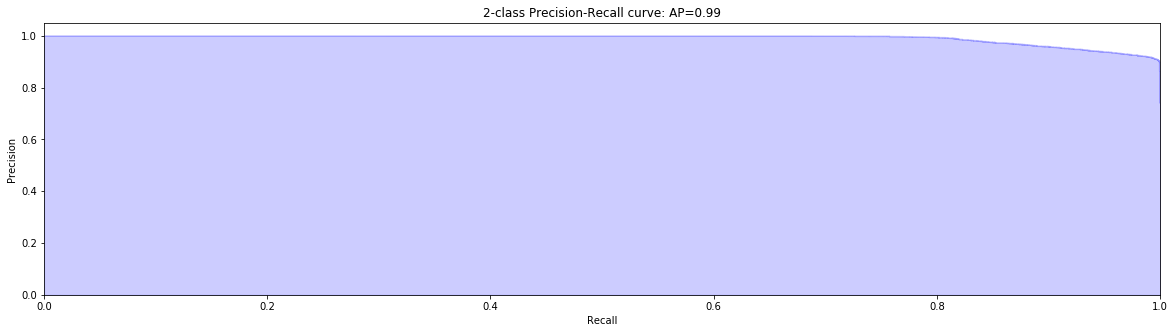

In [61]:
# Following scikit-learn tutorial

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, k = precision_recall_curve(test_target, norm_acc_probas)

plt.figure(figsize=(20,5))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          avg_precision_score))


In [62]:
for i in range(len(k)):
    if recall[i] <0.95:
        print("k: " + str(k[i-2]))
        print("Precision: " + str(precision[i-2]))
        print("Recall: " + str(recall[i-1]))
        break


k: 0.6175830867477533
Precision: 0.9382614647501711
Recall: 0.9519444444444445


Given the precision-recall curve, I would like to choose a value where recall and precision are both high, with the importance placed slightly more on recall. I have chosen a k-value of 0.633, where the precision offered is 0.941, which is only slightly lower than the recall of 0.950. This point offers good results in both the precision and recall aspects, but a slight focus on recall to mitigate the amount of false negatives.

## Section 4 - Conclusion

In conclusion, it seems that the random forest classifier with 200 estimators and max depth of 20 is the best performing model for this dataset. While the SVC with RBF kernel performed similarly to the default Random Forest, the trade-off of having to wait so much longer for it to run for marginal performance gains only in weighted precision, makes the Random Forest a better choice. Having done a few iterations, there were only marginal gains of less than 0.01. Something interesting to note was the similar performances of a Random Forest by only considering 4 features, which is of interest in the future if creating a smaller pipeline. 

Overall, this dataset allowed for a lot more feature engineering, and having domain knowledge would have made the process a lot easier.Another consideration would have been to perform tfidf, which works on text data. By creating more features, the results might have been made better for linear models, such as linear SVC and logistic regression. However, the URIs given may not tokenize, easily esp with the format of certain links (embedding symbols between words), and a mix of Spanish and English words.